# OOP Version


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import re
import folium
import json
import matplotlib.pyplot as plt
import seaborn as sns

<h2> Define Functions

<h3>Web Scraping housing information

In [2]:
# scrape listing info
def get_housings(url): 
    housings_list = list()
    import requests
    from bs4 import BeautifulSoup
    # Request for home page of NY housing info
    try:
        results_page = requests.get(url)
    except:
        return None
    try:
        soup = BeautifulSoup(results_page.content,'lxml')
    except:
        return None
    # Get all the feature housings and bold housings on the first page
    feature_housings = soup.find_all('article',class_='panel-listing-result listing-featured ')
    for housing in feature_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
    # Second Type of housing
    all_housings = soup.find_all('article', class_='panel-listing-result listing-bold ')
    for housing in all_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            detail_dict['Short_description'] = name
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
    # Third type of housing:
    early_bird_housings = soup.find_all('article', class_='panel-listing-result listing-free ')
    for housing in early_bird_housings:
        if housing.find('a'):
            detail_dict = dict()
            name = housing.find('h1').get_text()
            size = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").get_text()
            detail_dict['Short_description'] = name
            location = housing.find('div', class_='pricingInfo').find('em',class_="shortDescription").find('span', class_='listingLocation').get_text()
            # Split the room size and the location and store only size
            for i in range(1,len(size)):
                if size[i].isupper(): 
                    position = i
                    break
            detail_dict['Size'] = size[:position]
            detail_dict['Location'] = location
            link = 'https://www.spareroom.co.uk' + housing.find('a').get('href')
            housings_list.append([detail_dict,link])
#     Turn to next page and get more housings
    if soup.find('ul',class_='navnext'):
        if soup.find('ul',class_='navnext').find('a'):
            next_page_token = soup.find('ul',class_='navnext').find('a').get('href')
            next_page = 'https://www.spareroom.co.uk/flatshare/' + next_page_token
        # Use recursion to get all the attractions    
            housings_list.extend(get_housings(next_page))
    return housings_list

In [3]:
# scraping detailed info
def get_details(list_leeds):
    count = 0 
    full_dict = dict()
    for dict_info, link in list_leeds:
        import requests
        from bs4 import BeautifulSoup
        # Request for details of each housing in NY
        try:
            results_page = requests.get(link)
        except:
            continue
        try:
            soup = BeautifulSoup(results_page.content,'lxml')
        except:
            continue
        # Get housing price for each room 
        price_list = list()
        if soup.find('ul', class_='room-list'): 
            prices = soup.find('ul', class_='room-list')
            price = prices.find_all('strong', class_='room-list__price')
            for price_i in price:
                price_list.append(price_i.get_text())
        if not price_list:
            if soup.find('section', class_='feature feature--price-whole-property'):
                price = soup.find('h3', class_='feature__heading')
                price_list.append(price.get_text())
        # Clean the data to remove 'Availability' in the price list
        if 'Availability' in price_list:
            price_list.remove('Availability')
        dict_info['Price'] = price_list
        # Get Availability for each housing
        avail = soup.find('section', class_='feature feature--availability')
        if avail:
            all_info_avail = avail.find_all('dd', class_='feature-list__value')
            availablility = all_info_avail[0].get_text()      
            min_period = all_info_avail[1].get_text()      
            max_period = all_info_avail[2].get_text() 
            dict_info['Availablility'] = availablility
            dict_info['Min_period'] = min_period
            dict_info['Max_period'] = max_period
        # Get Amenities info for each housing
        amenities = soup.find('section', class_='feature feature--amenities')
        if amenities:
            all_info_amenities = amenities.find_all('dd', class_='feature-list__value')
            if all_info_amenities:
                furnish = all_info_amenities[0].get_text()
                dict_info['Furnishing'] = furnish
        else:
            dict_info['Furnishing'] = 'No info'
        # Female/Male requirement
        preference = soup.find('section', class_='feature feature--household-preferences')
        if preference:
            preference_info = preference.find_all('dt', class_='feature-list__key')
            preference_detail = preference.find_all('dd', class_='feature-list__value')
            if preference_info and preference_detail:
                for info in preference_info:
                    if info.get_text() == 'Gender':
                        info_index = preference_info.index(info)
                        break
                try:
                    gender = preference_detail[info_index].get_text() 
                    dict_info['Gender_requirement'] = gender
                except:
                    dict_info['Gender_requirement'] = 'No info'
        full_dict[count] = dict_info
        count = count + 1
#     return price_list
    return full_dict

### Data Clean

In [4]:
def clean(dict_):
    for key in dict_.keys():
        for subkey in dict_[key].keys():
            if isinstance(dict_[key][subkey], str):
                dict_[key][subkey] = dict_[key][subkey].lstrip().rstrip()
    # Clean the price list
    for key in dict_.keys():
        list_in = list()
        for item in list(dict_[key]['Price']):
            list_in.append(item.strip('\n'))
        dict_[key]['Price'] = list_in
        
    df_info = pd.DataFrame(dict_)
    df_info = df_info.T

    # Fix furnished problem
    for i in df_info.index:
        if df_info.iloc[i]['Furnishing'] in ['Furnished', 'Part Furnished', 'Unfurnished']:
            pass
        else:
            df_info.iloc[i]['Furnishing'] = 'No info'
    # Fix Gender_requirement problem
    for i in df_info.index:
        if df_info.iloc[i]['Gender_requirement'] in ['Males or females', 'Female preferred', 'No info','Male preferred']:
            pass
        else:
            df_info.iloc[i]['Gender_requirement'] = 'No info'
    # Create a new col in df_info to store average price for a single person
    pattern = r'\d+'  
    price_per_month = list()

    for i in df_info.index:
        list_in_price = list()
        for item in df_info.iloc[i]['Price']:
            item = item.replace(',', '')
            if 'pw' in item:
                price_info = int((re.findall(pattern, item))[0])
                list_in_price.append(price_info*4)
            if 'pcm' in item:
                price_info = int((re.findall(pattern, item))[0])
                list_in_price.append(price_info)
        price_per_month.append(list_in_price)
    price_per_month = np.array(price_per_month)
    df_info['Price_per_month'] = price_per_month
    list_avg_price = list()
    for i in df_info.index:
        list_avg_price.append(np.mean(df_info.iloc[i]['Price_per_month']) )
    df_info['Average_price_per_month'] = np.array(list_avg_price)
    # Create a new col in df_info to store zip code for each housing
    # Create a new col for zip code
    list_pos = list()
    for i in df_info.index:
        for s in df_info.iloc[i]['Location']:
            if s == '(':
                position = df_info.iloc[i]['Location'].index(s)
                break
        list_pos.append(df_info.iloc[i]['Location'][position:].strip('(').strip(')'))
    df_info['Postal_code'] = np.array(list_pos)
    # clean nan from df
    df_info = df_info.dropna()
    # reset index
    df_info = df_info.reset_index()
    return df_info

### Data Visualization

In [5]:
%matplotlib inline
plt.style.use('seaborn')

In [6]:
# a function to use google api to get the lat and lng for a location
def get_lat_lng(address_string,api_key):
    url=f"https://maps.googleapis.com/maps/api/geocode/json?address={address_string}&key={api_key}" 
    import requests
    response = requests.get(url)
    if response.status_code != 200:
        print('Something went wrong about requests due to internet problem or typing error.')
    else:
        try:
            response_ = response.json()
        except:
            print("Sth wrong with json decoding process")
        return [response_['results'][0]['geometry']['location']['lat'],response_['results'][0]['geometry']['location']['lng']]

In [7]:
# input data should be df_info.groupy().size() 
def plot_bar(data, title, figsize=(6,4), sort = False):
    if sort:
        data.sort_values(ascending=False).plot(kind='bar', title=title, figsize = figsize)
    else:
        data.plot(kind='bar', title=title, figsize = figsize)

In [8]:
# input data should be df_info.groupy().size() 
def plot_pie(data, title, figsize=(6,4)):
    label = data.index
    fig1, ax1 = plt.subplots(figsize=figsize)
    ax1.pie(data, labels = label, autopct='%1.1f%%', startangle=90)
    ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.title(title, fontsize=15, fontweight='bold')
    plt.legend()
    plt.show()

In [9]:
def distplot(data,array):
    array = data['Average_price_per_month'].astype('float')
    return sns.distplot(array)

In [10]:
def heatmap(df_info, location, kind, api_key=False):
    zip_groups = df_info.groupby('Postal_code')
    sizes = zip_groups.size()
    sizes = sizes.rename("size")
    avg_price = zip_groups.Average_price_per_month.mean()
    info_group_by_zip = pd.concat([sizes, avg_price], axis = 1)
    info_group_by_zip['zip'] = info_group_by_zip.index
    
    # read the geojson file and get all the postcode
    filename = location.lower() + '_postcodes.geojson'
    with open(filename,'r') as load_f: 
        geojson = json.load(load_f)

    # drop zip zone that we don't have data in geojson
    geojson['features'] = [item for item in geojson['features'] if item['properties']['Name'] in info_group_by_zip.index]
    
    # set each city's center location
    center = {}
    if api_key:
        center[location] = get_lat_lng(location,api_key)
    else:
        center['Manchester'] = [53.483959, -2.244644]
        center['London'] = [51.5074, 0.1278]
        center['Liverpool'] = [53.3, -3]
        center['Leeds'] = [53.8008, -1.5491]
    
    if kind == 'size':
        m = folium.Map(location = center[location], zoom_start=10) ####
        m.choropleth(geo_data=geojson, data=info_group_by_zip, 
                     columns=['zip','size'],
                     key_on='feature.properties.Name',
                     fill_color='YlGn', fill_opacity=0.7, line_opacity=0.8,
                     legend_name='the number of housings')
        folium.LayerControl().add_to(m)
        return m
    
    if kind == 'price':
        m = folium.Map(location = center[location], zoom_start=10) ###
        m.choropleth(geo_data=geojson, data=info_group_by_zip, 
                     columns=['zip','Average_price_per_month'],
                     key_on='feature.properties.Name',
                     fill_color='GnBu', fill_opacity=0.7, line_opacity=0.8,
                     legend_name='average housing price')
        return m

In [11]:
# Group the average price
def GroupColFunc(df, ind, col):
        if df[col].loc[ind] < 500:
            return 'Lower than 500'
        elif 1000 > df[col].loc[ind] >= 500:
            return 'Between 500 and 1000'
        elif 1500 > df[col].loc[ind] >= 1000:
            return 'Between 1000 and 1500'
        else:
            return 'Above 1500'
        
def avg_price_groups(df):
    avg_price_group = df.groupby(lambda x: GroupColFunc(df, x, 'Average_price_per_month')) 
    return avg_price_group.size().plot(kind='bar', title='Housing average price')

In [12]:
# Group by average price and another group
def two_group_analysis(df, col):
    # Add a col of average price group for further analysis
    avg_price_list = list()
    for i in df.index:
        avg_price_list.append(GroupColFunc(df, i, 'Average_price_per_month'))
    df['Avg_price_group'] = np.array(avg_price_list)
    col_avg_groups = df.groupby([col,'Avg_price_group']).size().unstack()
    COL_NUM = 2
    ROW_NUM = 2
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(12,12))

    for i, (avg, col) in enumerate(col_avg_groups.items()): 
        ax = axes[int(i/COL_NUM), i%COL_NUM]
        col = col.sort_values(ascending=False) # sort the data in descending order 
        col.plot(kind='barh', ax=ax)
        ax.set_title(avg)

    return plt.tight_layout()

## Create a blueprint for all the four cities

In [13]:
class Rental:
    def __init__(self, url, location):
        self.location = location
        self.url = url
        self.dict_ = get_details(get_housings(self.url))
    @property
    def df(self):
        return clean(self.dict_)

    # kind should be 'bar' or 'pie'
    def gender_preference_analysis(self, kind):
        group = self.df.groupby('Gender_requirement')
        size = group.size()
        title = 'Gender requirement for rent in ' + self.location
        if kind == 'bar':
            plot_bar(size, title, sort = False)
        if kind == 'pie':
            plot_pie(size, title)
    
    # kind should be 'bar' or 'heatmap'
    def size_analysis(self, kind, api_key=False):
        if kind == 'bar':
            group = self.df.groupby('Postal_code')
            size = group.size()
            title = 'the number of listings in each zip zone in ' + self.location
            plot_bar(size, title, figsize=(24,12), sort = True)
        if kind == 'heatmap':
            return heatmap(self.df, self.location, 'size', api_key = api_key)
    
    # kind shoud be 'bar' or 'pie'
    def furnishing_analysis(self, kind):
        group = self.df.groupby('Furnishing')
        size = group.size()
        title = 'Furnishing status of housing in ' + self.location 
        if kind == 'bar':
            plot_bar(size, title, sort = False)
        if kind == 'pie':
            plot_pie(size, title)
    
    # kind shoud be 'bar' or 'pie'
    def room_type_analysis(self, kind):
        group = self.df.groupby('Size')
        size = group.size()
        title = 'room type in ' + self.location
        if kind == 'bar':
            plot_bar(size, title, sort = False)
        if kind == 'pie':
            plot_pie(size, title, figsize=(12,12))
    
    # kind should be 'heatmap', 'distplot', 'group_analysis'
    # NEED MORE ANALYSIS ABOUT PRICE
    def price_analysis(self, kind, api_key = False):
        if kind == 'heatmap':
            return heatmap(self.df, self.location, 'price', api_key = api_key)
        if kind == 'distplot':
            return distplot(self.df, self.df['Average_price_per_month'])
        if kind == 'group_analysis':
            return avg_price_groups(self.df)
        
    # col is one of the column in the df
    def price_group_analysis(self, col):
        return two_group_analysis(self.df, col)

## Manchester

In [14]:
url_Manchester = 'https://www.spareroom.co.uk/flatshare/?search_id=749193487&'

In [15]:
Manchester = Rental(url_Manchester, 'Manchester')

/usr/local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


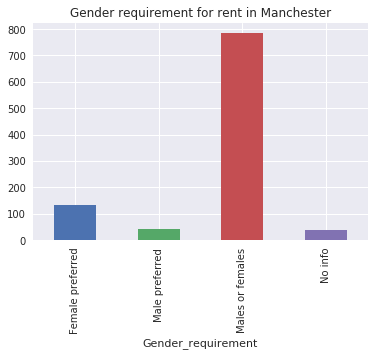

In [16]:
Manchester.gender_preference_analysis('bar')

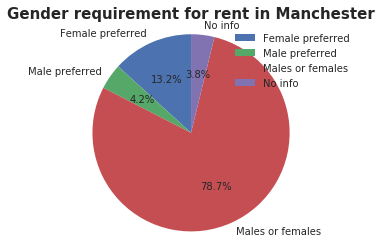

In [17]:
Manchester.gender_preference_analysis('pie')

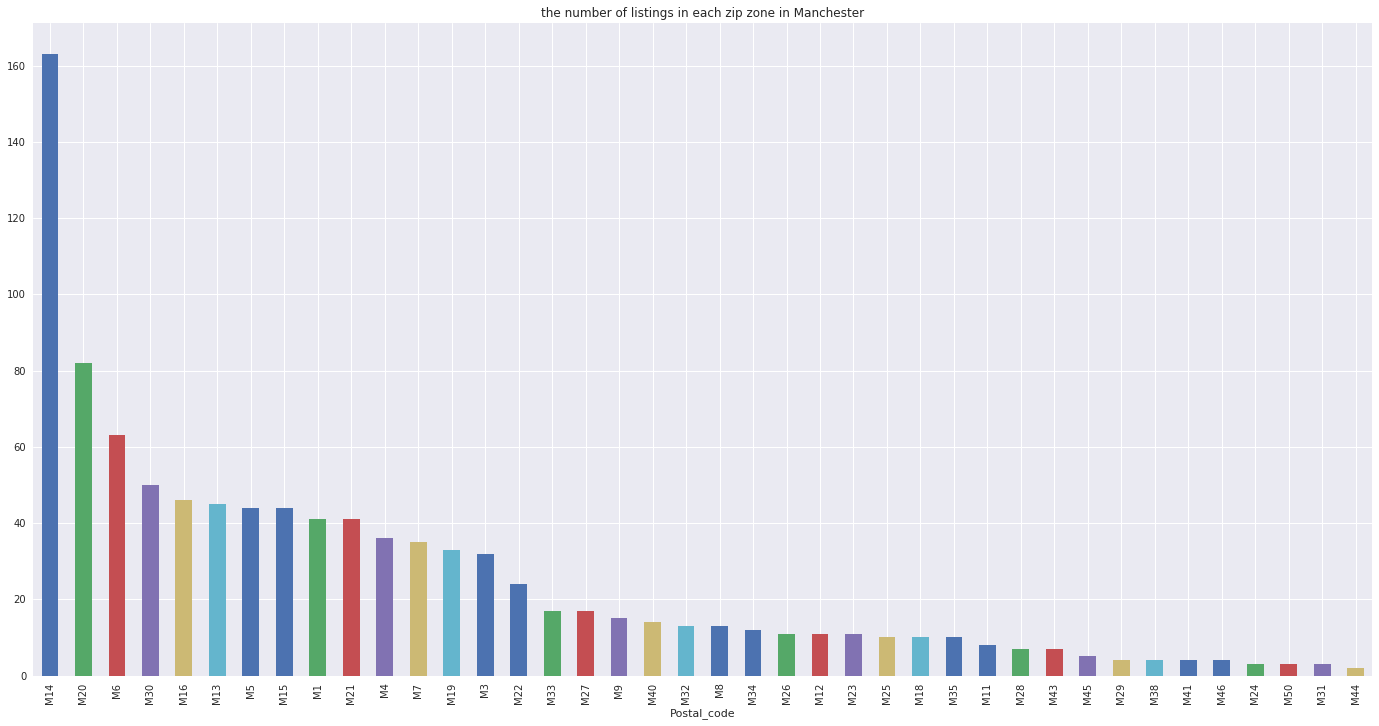

In [18]:
Manchester.size_analysis('bar')

In [19]:
Manchester.size_analysis('heatmap', api_key = False)

/usr/local/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


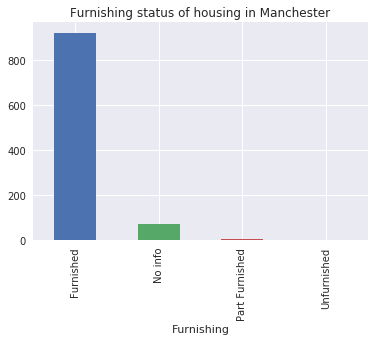

In [20]:
Manchester.furnishing_analysis('bar')

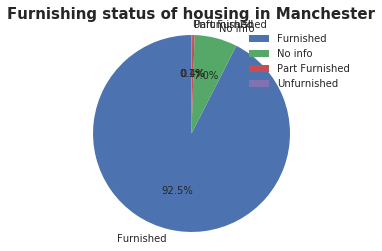

In [21]:
Manchester.furnishing_analysis('pie')

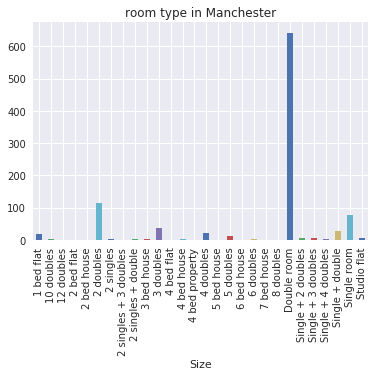

In [22]:
Manchester.room_type_analysis('bar')

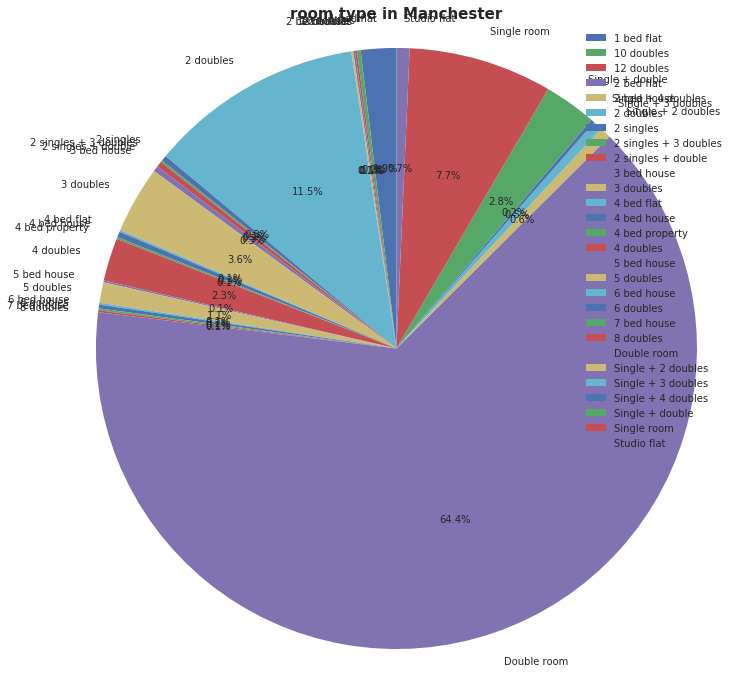

In [23]:
Manchester.room_type_analysis('pie')

In [24]:
Manchester.price_analysis('heatmap', api_key = False)

/usr/local/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


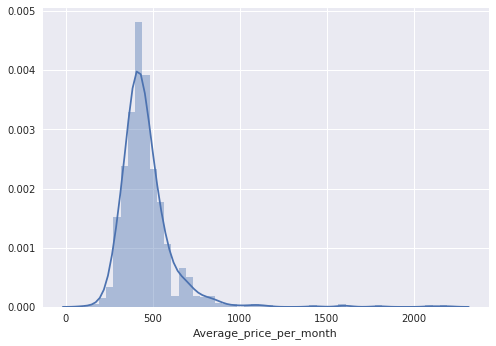

In [25]:
Manchester.price_analysis('distplot')

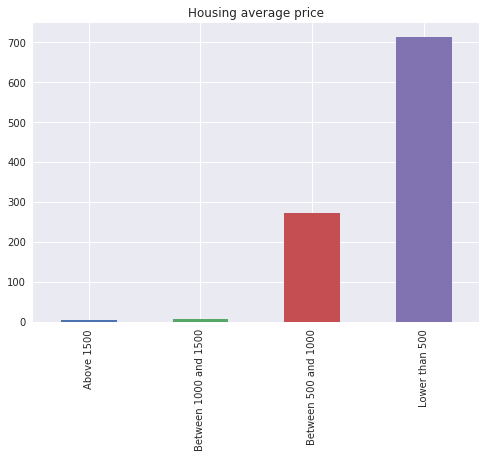

In [26]:
Manchester.price_analysis('group_analysis')

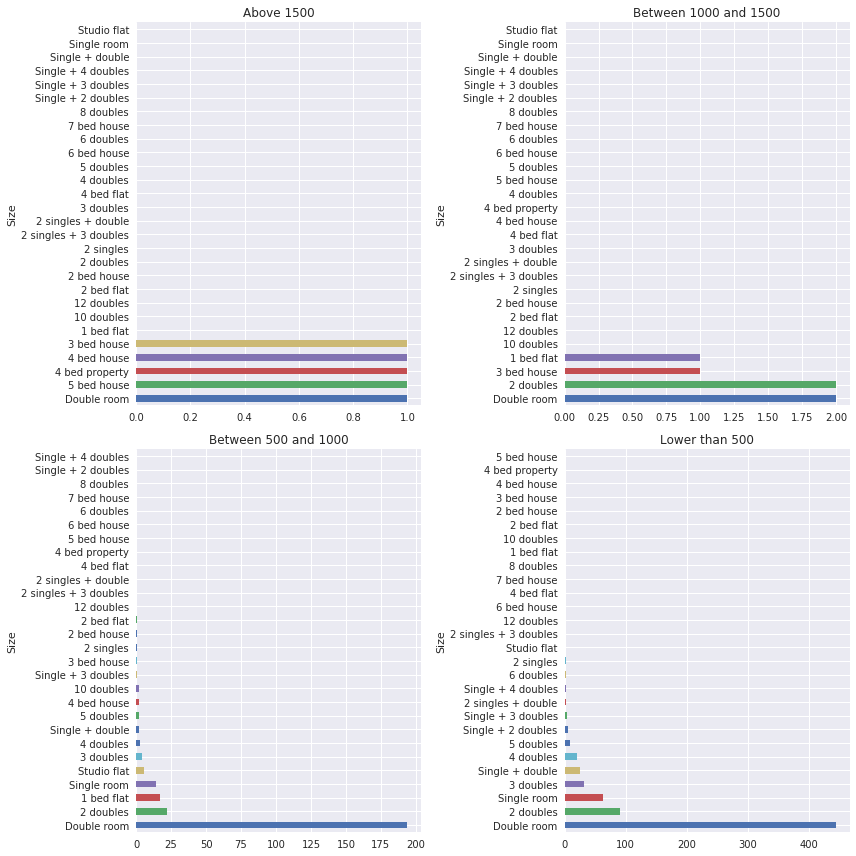

In [27]:
Manchester.price_group_analysis('Size')

<h1> London

In [28]:
url_London = 'https://www.spareroom.co.uk/flatshare/?search_id=745817425&'

In [29]:
London = Rental(url_London, 'London')

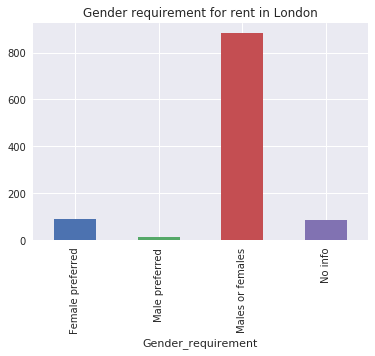

In [30]:
London.gender_preference_analysis('bar')

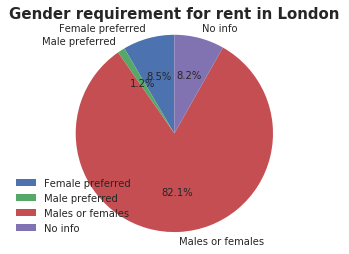

In [31]:
London.gender_preference_analysis('pie')

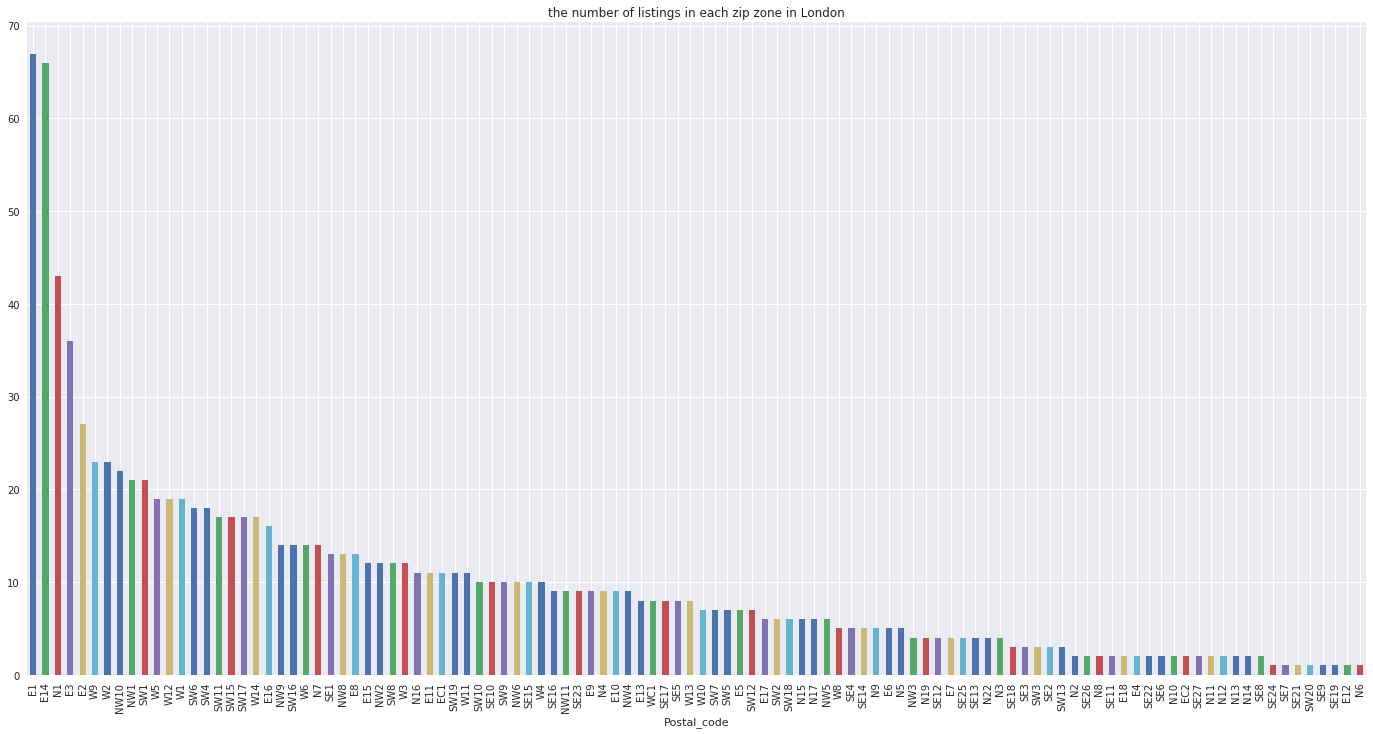

In [32]:
London.size_analysis('bar')

In [33]:
London.size_analysis('heatmap', api_key = False)

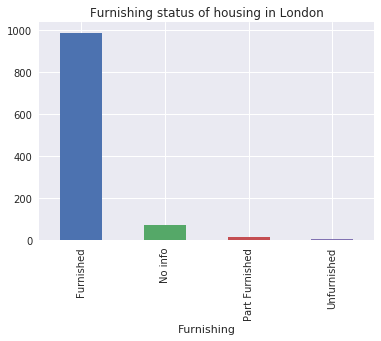

In [34]:
London.furnishing_analysis('bar')

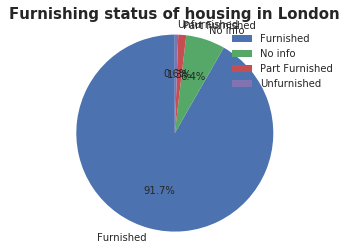

In [35]:
London.furnishing_analysis('pie')

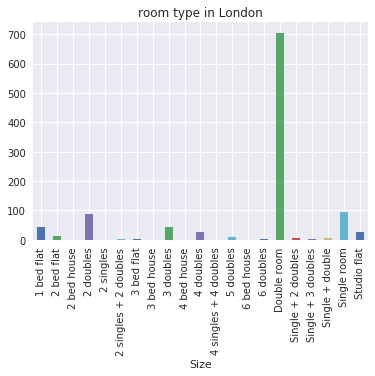

In [36]:
London.room_type_analysis('bar')

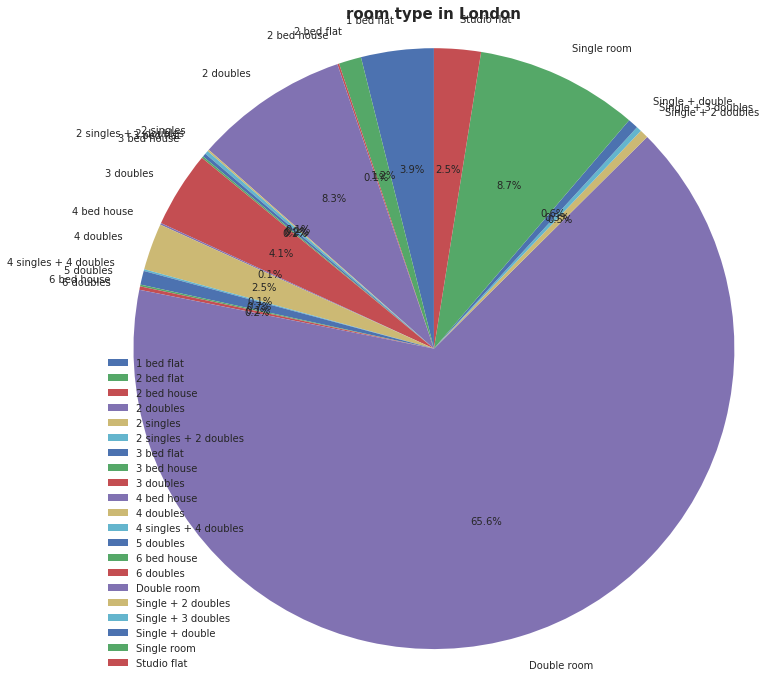

In [37]:
London.room_type_analysis('pie')

In [38]:
London.price_analysis('heatmap', api_key = False)

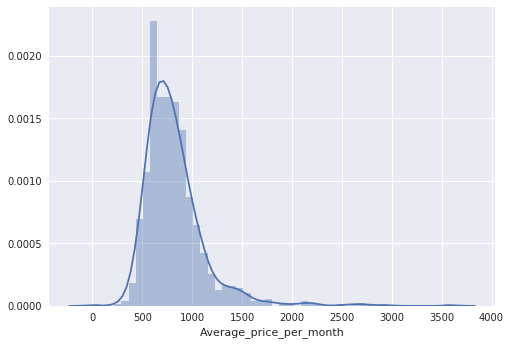

In [39]:
London.price_analysis('distplot')

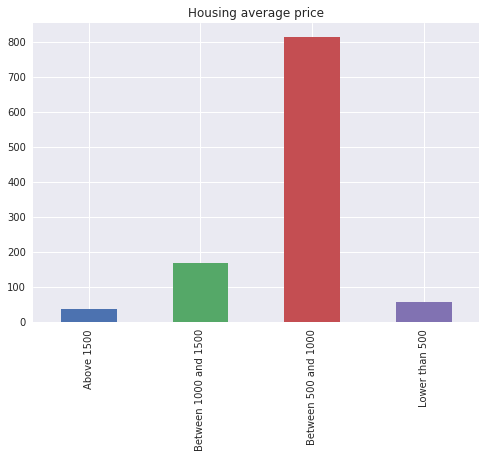

In [40]:
London.price_analysis('group_analysis')

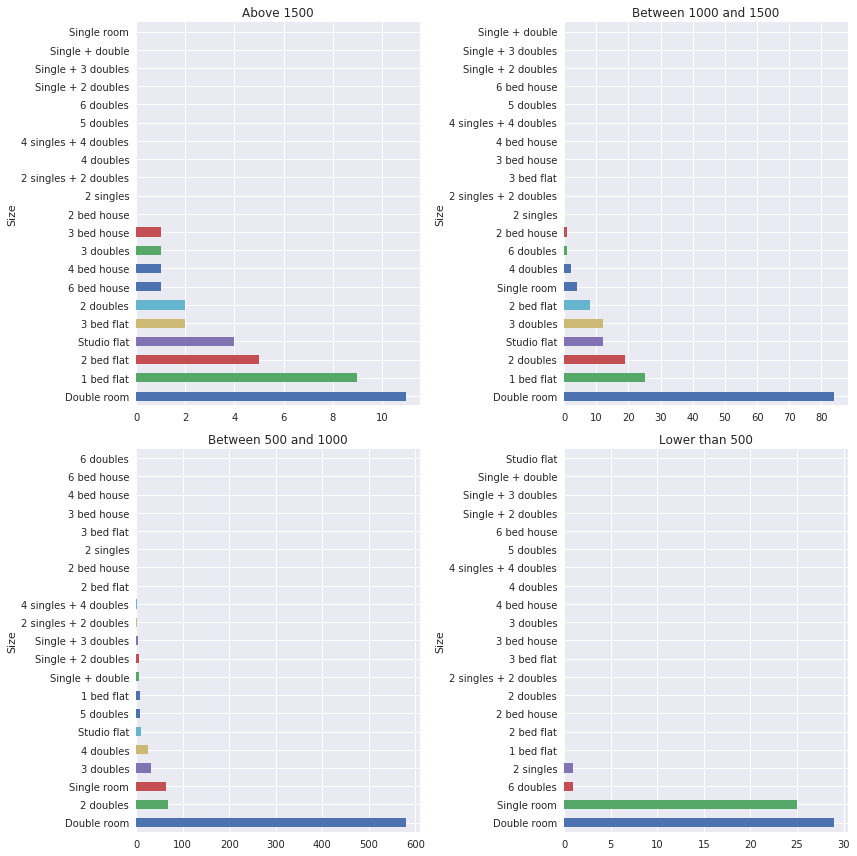

In [41]:
London.price_group_analysis('Size')

<h1> Leeds

In [42]:
url_leeds = 'https://www.spareroom.co.uk/flatshare/?search_id=748742143&'

In [43]:
Leeds = Rental(url_leeds, 'Leeds')

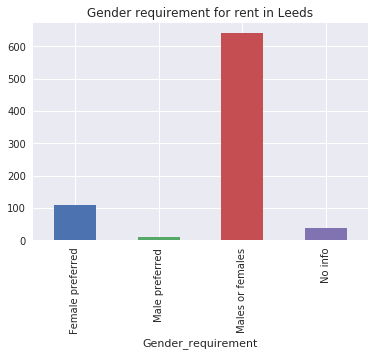

In [44]:
Leeds.gender_preference_analysis('bar')

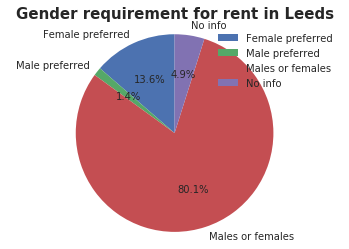

In [45]:
Leeds.gender_preference_analysis('pie')

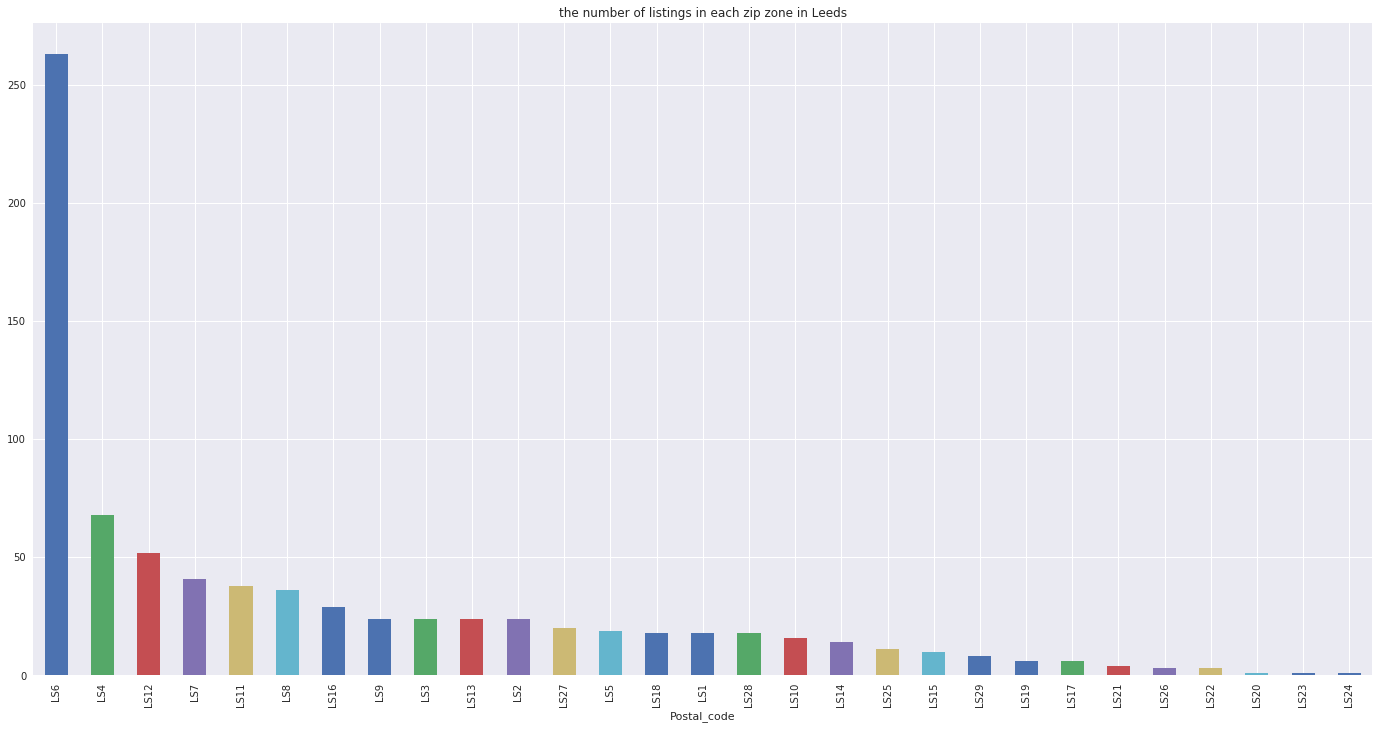

In [46]:
Leeds.size_analysis('bar')

In [47]:
Leeds.size_analysis('heatmap', api_key = False)

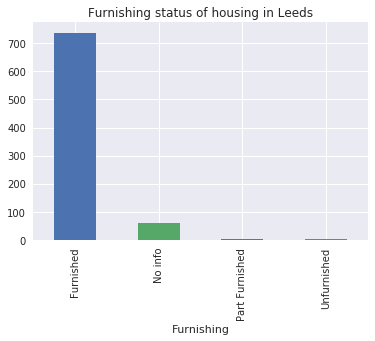

In [48]:
Leeds.furnishing_analysis('bar')

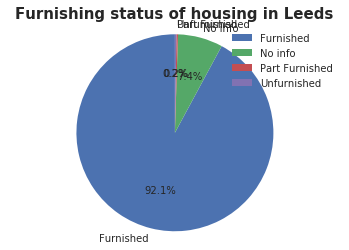

In [49]:
Leeds.furnishing_analysis('pie')

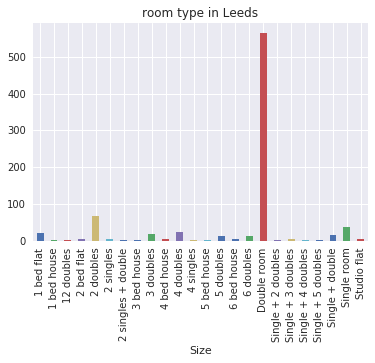

In [50]:
Leeds.room_type_analysis('bar')

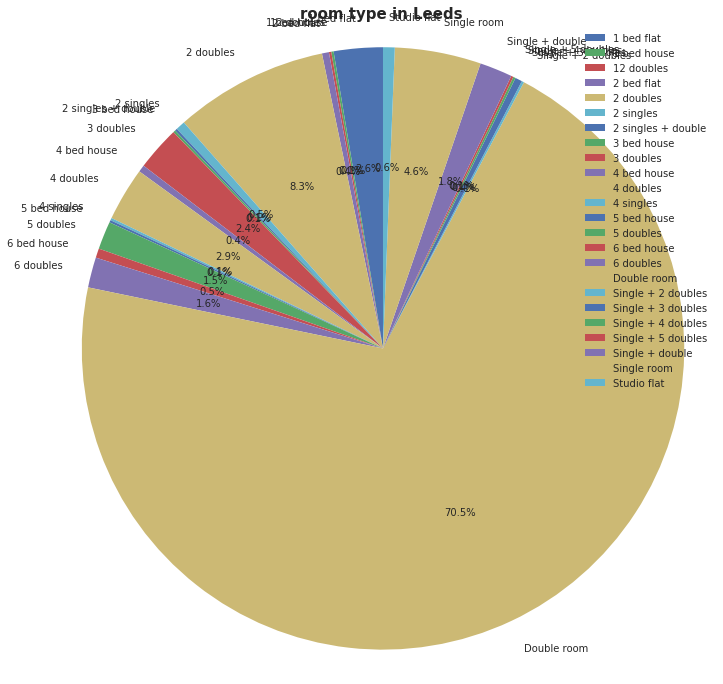

In [51]:
Leeds.room_type_analysis('pie')

In [52]:
Leeds.price_analysis('heatmap', api_key = False)

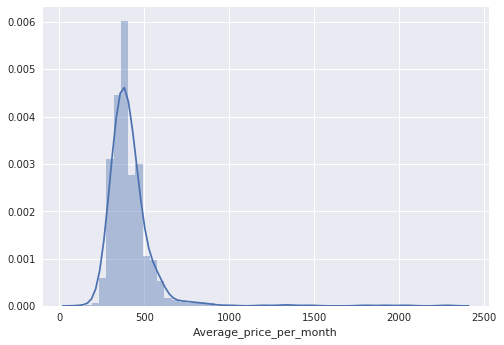

In [53]:
Leeds.price_analysis('distplot')

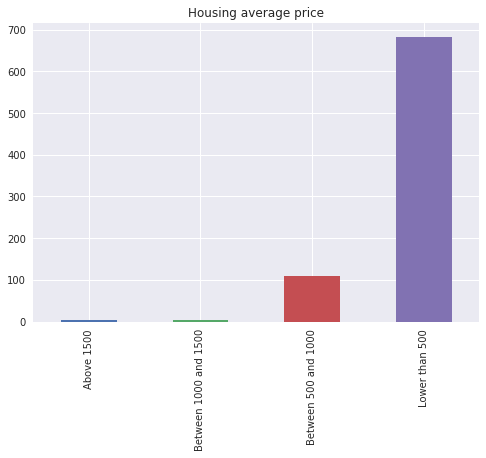

In [54]:
Leeds.price_analysis('group_analysis')

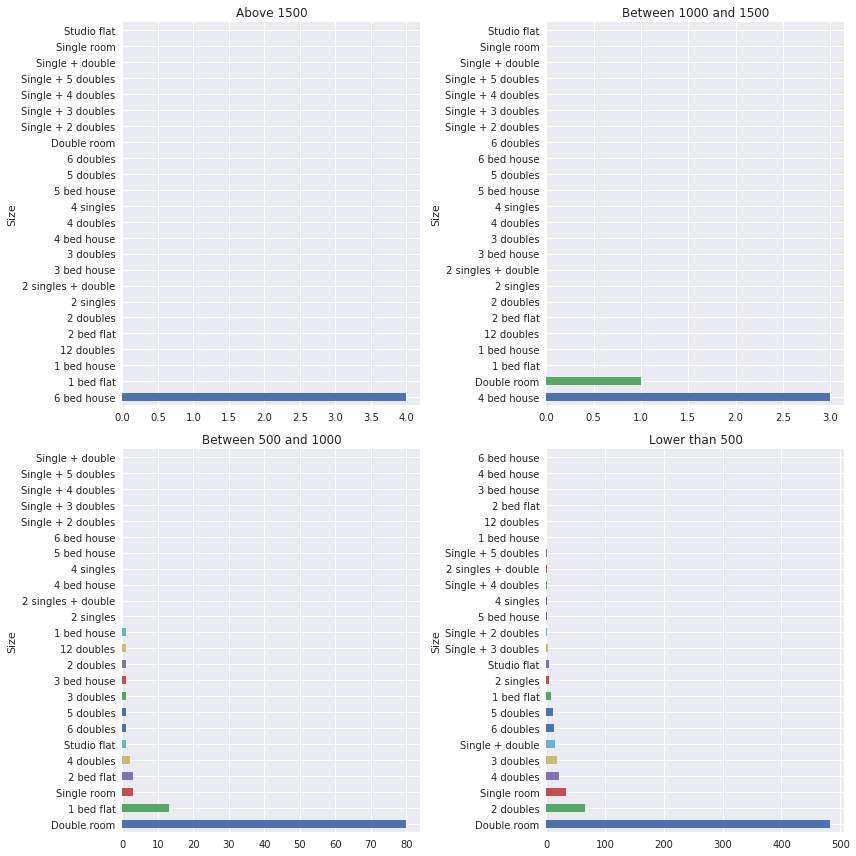

In [79]:
Leeds.price_group_analysis('Size')

<h1> Liverpool

In [55]:
url_liver = 'https://www.spareroom.co.uk/flatshare/?search_id=746073457&'

In [56]:
Liverpool = Rental(url_liver, 'Liverpool')

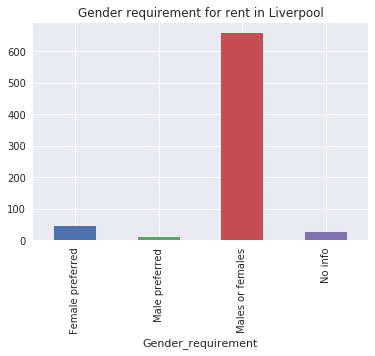

In [57]:
Liverpool.gender_preference_analysis('bar')

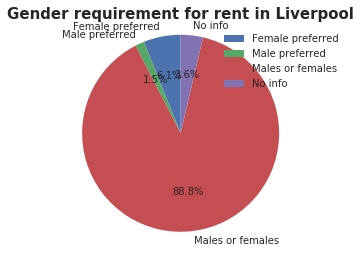

In [58]:
Liverpool.gender_preference_analysis('pie')

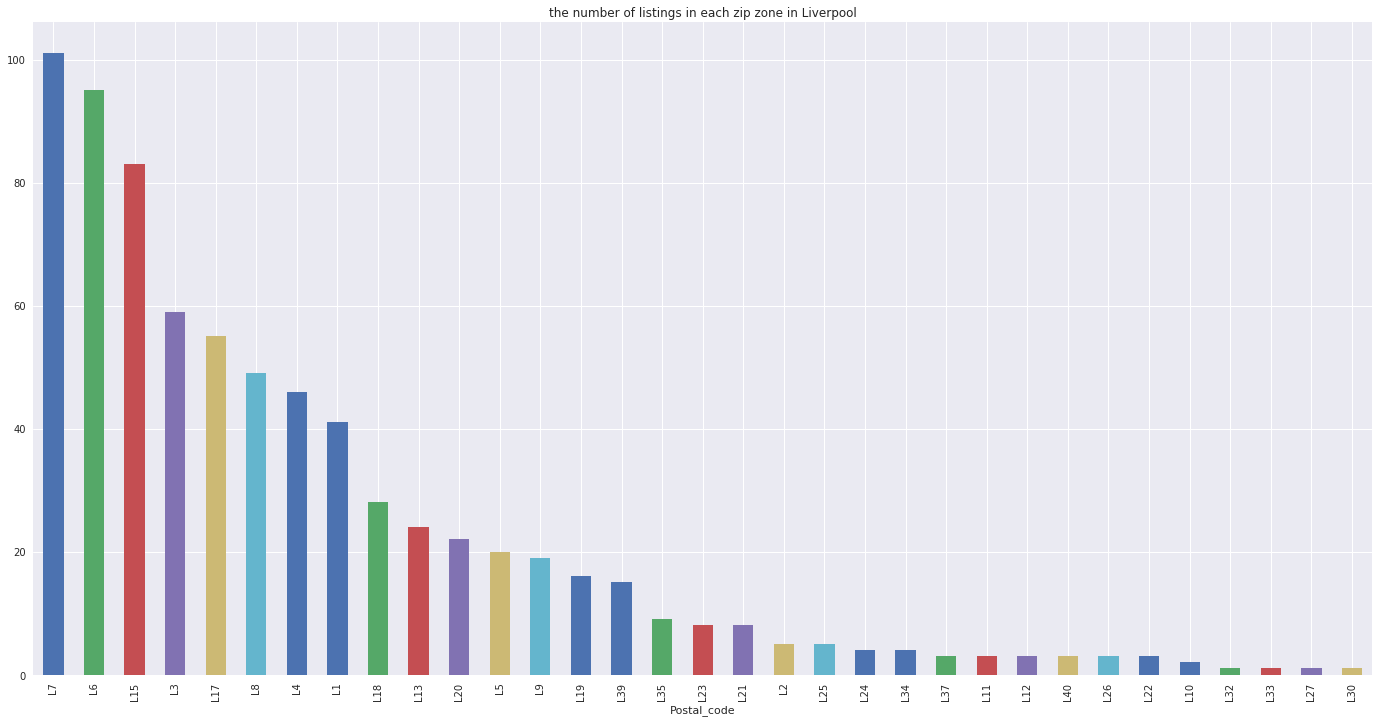

In [59]:
Liverpool.size_analysis('bar')

In [60]:
Liverpool.size_analysis('heatmap', api_key = False)

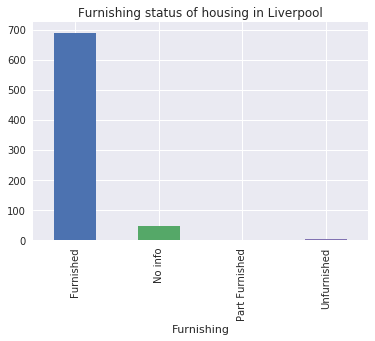

In [61]:
Liverpool.furnishing_analysis('bar')

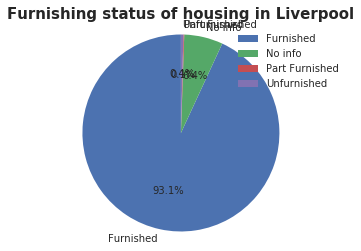

In [62]:
Liverpool.furnishing_analysis('pie')

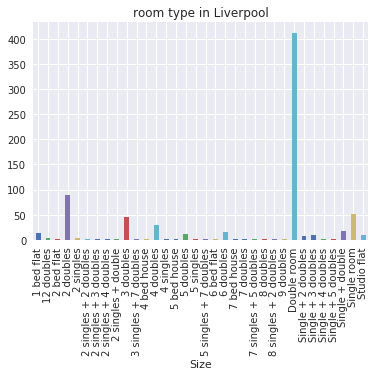

In [63]:
Liverpool.room_type_analysis('bar')

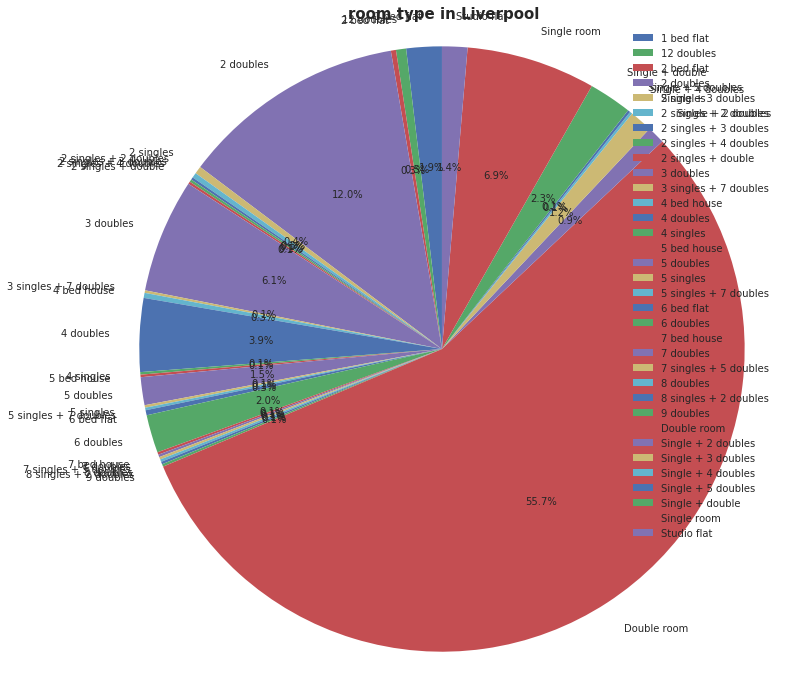

In [64]:
Liverpool.room_type_analysis('pie')

In [65]:
Liverpool.price_analysis('heatmap', api_key = False)

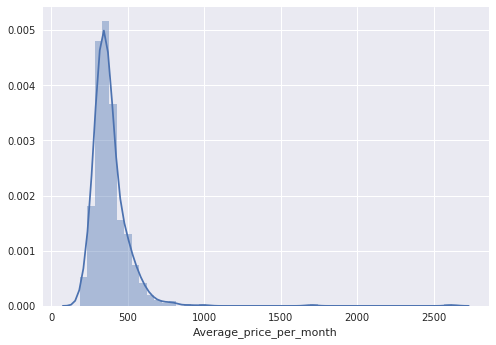

In [66]:
Liverpool.price_analysis('distplot')

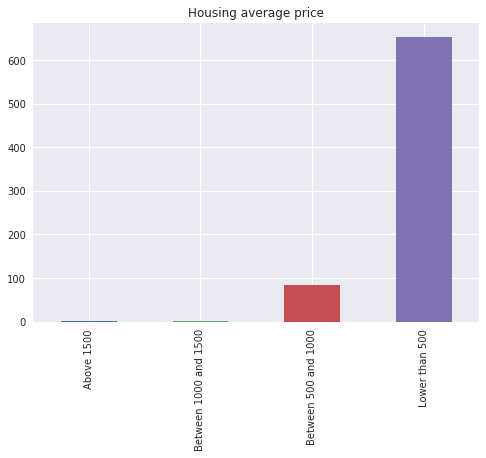

In [67]:
Liverpool.price_analysis('group_analysis')

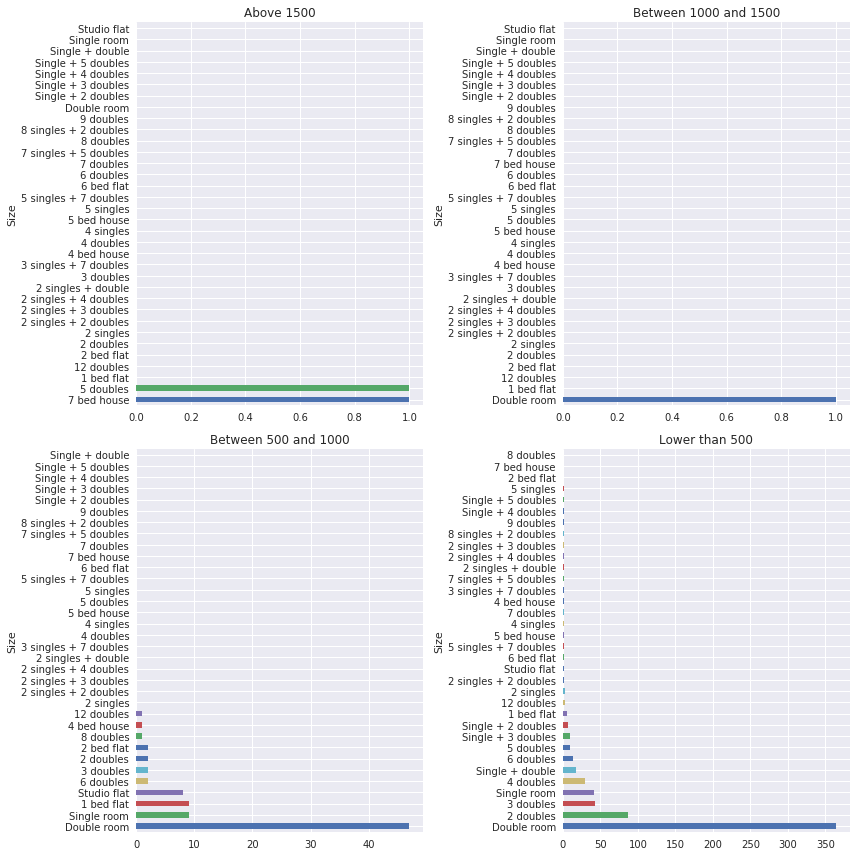

In [68]:
Liverpool.price_group_analysis('Size')

<h2>Further analysis

In [69]:
london_df = pd.read_csv('London.csv')
manchester_df = pd.read_csv('Manchester.csv')
leeds_df = pd.read_csv('Leeds.csv')
liverpool_df = pd.read_csv('Liverpool.csv')
london_df['Region'] = 'London'
manchester_df['Region'] = 'Manchester'
leeds_df['Region'] = 'Leeds'
liverpool_df['Region'] = 'Liverpool'

In [70]:
# Append all four dataframe into one to do more analysis
all_four_df = london_df.append(manchester_df).append(leeds_df).append(liverpool_df)
all_four_df = all_four_df.reset_index()
# Read population from official census file
population = pd.read_csv('pop_by_zip.csv')
population.set_index('Postcode Districts', inplace=True)
# add population info to all_four_df
popu_list = list()
for item in all_four_df.index:
    if all_four_df.iloc[item]['Postal_code'] in population.index:
        popu_list.append(population.loc[all_four_df.iloc[item]['Postal_code']]['2011'])
    else:
        popu_list.append('No info')
all_four_df['Population_in_this_region'] = popu_list
# Clean the new dataframe 
# Drop meaningless columns
all_four_df = all_four_df.drop(columns=['index','Unnamed: 0'])
# Delete comma in the column
all_four_df['Population_in_this_region'] = [item.replace(',', '') for item in all_four_df['Population_in_this_region']]
# Round up to 1 decimal
all_four_df['Average_price_per_month'] = [float(f"{all_four_df.iloc[i]['Average_price_per_month']:.2}") for i in all_four_df.index]

In [71]:
price_df_zip = all_four_df.groupby('Postal_code').mean()

<h3>Draw a scatter plot between population and rental price


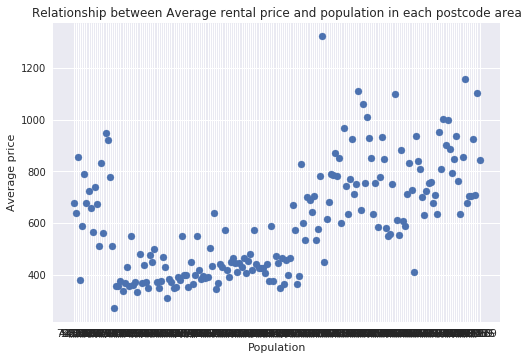

In [72]:
# Draw a scatter plot between population and rental price
list_popu_analysis = [(price_df_zip.loc[item]['Average_price_per_month'], population.loc[item]['2011'])
    for item in price_df_zip.index if item in population.index]

fig = plt.figure()
ax1 = fig.add_subplot(111)

# Set title
ax1.set_title('Relationship between Average rental price and population in each postcode area')
# Set x label 
plt.xlabel('Population')
# Set x label
plt.ylabel('Average price')
ax1.scatter(x=[item[1] for item in list_popu_analysis], y=[item[0] for item in list_popu_analysis])
# Show the graph
plt.show()

<h3> Draw a scatter plot between Selling price and rental price


In [73]:
# Selling price and rental price
buy_price_df = pd.read_csv('pp-monthly-update-new-version.csv')
buy_price_df = buy_price_df.dropna()

In [74]:
buy_price_df
# clean the postcode to select the first part
pattern = r'[A-Z0-9]+'
postcode = [re.match(pattern, item).group() for item in buy_price_df['Postcode']]

In [75]:
buy_price_df['Postcode_clean'] = postcode

In [76]:
# groupby cleaned postcode 
buy_price_df = buy_price_df.groupby('Postcode_clean').mean()

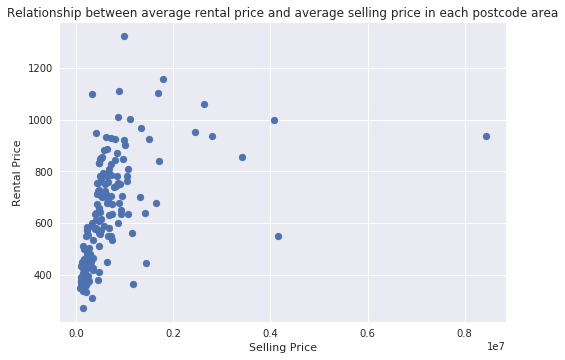

In [77]:
# draw the relationship btw buy price and rental price with the same postcode
list_buy_analysis = [(price_df_zip.loc[item]['Average_price_per_month'], buy_price_df.loc[item]['Price'])
    for item in price_df_zip.index if item in buy_price_df.index]

fig = plt.figure()
ax1 = fig.add_subplot(111)

# Set title
ax1.set_title('Relationship between average rental price and average selling price in each postcode area')
# Set x label 
plt.xlabel('Selling Price')
# Set x label
plt.ylabel('Rental Price')
ax1.scatter(x=[item[1] for item in list_buy_analysis], y=[int(item[0]) for item in list_buy_analysis])
# Show the graph
plt.show()

Here we can see from the two graph above that there is a positive relationship between selling price and rental price, and there is also a positive relationship between population in the area and the rental price

<h3> Distribution plot of the rental price for all four big cities in UK

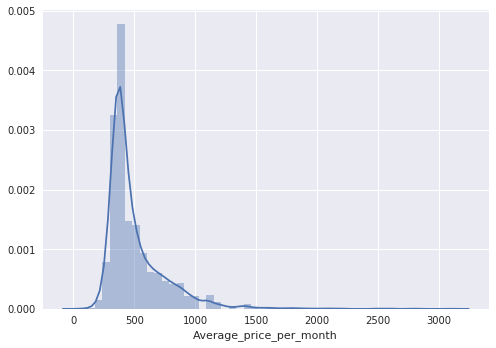

In [80]:
all_four_df = all_four_df.dropna()
distplot(all_four_df,'Average_price_per_month')